# Домашнее задание. Отток клиентов банка.

Используя данные файла train о характеристиках пользователей и факте расторжения договора, построим модель, предсказывающую, какие пользователи имеют высокий риск ухода.

# Метрика

В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. 

# Первая часть. Исследование

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Загрузка данных (2 балла)

Загрузим файл с данными, посмотрим на них.



In [2]:
!gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
!gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
!gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv

/bin/bash: gdown: command not found
/bin/bash: gdown: command not found
/bin/bash: gdown: command not found


In [3]:
data = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/train.csv')

In [4]:
data.info()
data.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
4981,2,79.20,172.85,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Electronic check,1
1215,7,78.50,571.05,Female,0,No,No,Yes,No,DSL,Yes,Yes,No,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,0
4537,11,23.15,245.2,Male,0,No,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),1
1726,13,70.15,916.75,Female,1,Yes,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
517,63,59.00,3707.6,Male,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Electronic check,0
4276,1,70.15,70.15,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,1
1960,58,84.30,4916.4,Female,0,Yes,No,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,0
4243,66,90.95,5930.05,Female,0,No,Yes,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,No,No,Two year,Yes,Credit card (automatic),0
4160,1,69.40,69.4,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Mailed check,1
907,62,23.65,1416.75,Female,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),0


В данных нет пропусков, есть числовые признаки и есть категориальные. Разделим их, а также выделим целевой признак:

In [5]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

В явном виде укажем у категориальных признаков тип 'category'

In [6]:
data[cat_cols] = data[cat_cols].astype('category')

Посмотрим на числовые данные:

In [7]:
data.describe()

,ClientPeriod,MonthlySpending,Churn
count,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,0.262022
std,24.550326,30.176464,0.439776
min,0.000000,18.250000,0.000000
25%,9.000000,35.462500,0.000000
50%,29.000000,70.400000,0.000000
75%,55.000000,90.050000,1.000000
max,72.000000,118.750000,1.000000


Столбец 'TotalSpent' является по сути, числовым.

In [8]:
data['TotalSpent'].sort_values()

4598          
2543          
4551          
1707          
3078          
         ...  
3557    996.85
141     996.95
4317    997.65
3376     998.1
1157     999.9
Name: TotalSpent, Length: 5282, dtype: object

Часть данных заполнена пробелами, посмотрим на них:

In [9]:
data[data['TotalSpent']==' ']

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


Видно, что это клиенты, только что заключившие договор (ClientPeriod=0). Заменим пробелы на нули. Чтобы можно было свободно оперировать данными (включая деление, подразумевающее отсутствие нулевых значений), создадим стоблец 'TotalSpent_next' - сумма оплаты в конце периода, добавив значение месячной оплаты 'MonthlySpending':

In [10]:
data['TotalSpent'] = data['TotalSpent'].replace(' ', 0).astype('float64')
data['TotalSpent_next'] = data['TotalSpent'] + data['MonthlySpending']

Убедимся, что в остальных категориальных признаках нет лишних значений:

In [11]:
for col in cat_cols:
    print (col)
    print (data[col].unique())

Sex
['Male', 'Female']
Categories (2, object): ['Female', 'Male']
IsSeniorCitizen
[0, 1]
Categories (2, int64): [0, 1]
HasPartner
['Yes', 'No']
Categories (2, object): ['No', 'Yes']
HasChild
['Yes', 'No']
Categories (2, object): ['No', 'Yes']
HasPhoneService
['Yes', 'No']
Categories (2, object): ['No', 'Yes']
HasMultiplePhoneNumbers
['No', 'Yes', 'No phone service']
Categories (3, object): ['No', 'No phone service', 'Yes']
HasInternetService
['No', 'Fiber optic', 'DSL']
Categories (3, object): ['DSL', 'Fiber optic', 'No']
HasOnlineSecurityService
['No internet service', 'No', 'Yes']
Categories (3, object): ['No', 'No internet service', 'Yes']
HasOnlineBackup
['No internet service', 'No', 'Yes']
Categories (3, object): ['No', 'No internet service', 'Yes']
HasDeviceProtection
['No internet service', 'No', 'Yes']
Categories (3, object): ['No', 'No internet service', 'Yes']
HasTechSupportAccess
['No internet service', 'Yes', 'No']
Categories (3, object): ['No', 'No internet service', 'Yes'

Значений, которые требовалось бы заменить,не выявлено. Посмотрим на дубликаты.

In [12]:
data[data.duplicated()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,...,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn,TotalSpent_next
1384,1,69.90,69.90,Male,0,No,No,Yes,No,Fiber optic,...,No,No,No,No,No,Month-to-month,Yes,Electronic check,1,139.8
1474,1,20.05,20.05,Male,0,No,No,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0,40.1
1636,1,19.65,19.65,Female,0,No,No,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0,39.3
1959,1,45.70,45.70,Male,0,No,No,Yes,No,DSL,...,No,No,No,No,No,Month-to-month,Yes,Mailed check,1,91.4
2036,1,69.35,69.35,Male,0,No,No,Yes,No,Fiber optic,...,No,No,No,No,No,Month-to-month,Yes,Electronic check,1,138.7
2586,1,20.20,20.20,Male,0,No,No,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,1,40.4
2877,1,70.10,70.10,Female,0,No,No,Yes,No,Fiber optic,...,No,No,No,No,No,Month-to-month,Yes,Electronic check,1,140.2
2991,1,20.90,20.90,Female,0,No,No,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,1,41.8
3660,1,20.45,20.45,Male,0,No,No,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0,40.9
3749,1,20.20,20.20,Male,0,No,No,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0,40.4


У нас нет ID пользователей, но нельзя исключить, что дубликаты относятся к разным ID, т.к. у нас не так много признаков, а у категориальных признаков не так много уникальных значений, поэтому 14 дублей на 5 тыс. элементов - вполне реальная картина.

## Анализ данных

Для численных призанков построим гистограммы распределений. Для категориальных посчитаем долю каждого значения для каждого признака, построив круговые диаграммы.
Посмотрим на распределение целевой переменной и баланс классов.  
Сначала выведем scatter_matrix и корреляции числовых признаков.

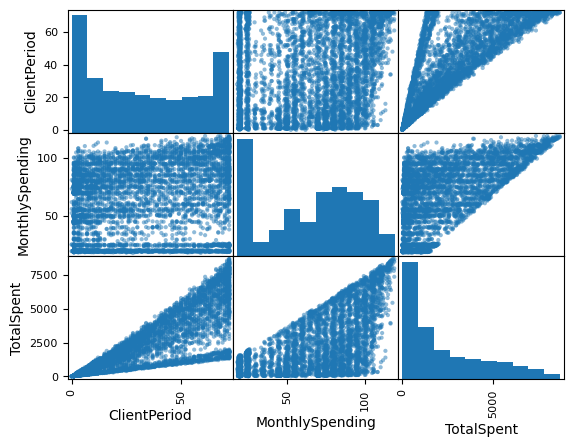

,ClientPeriod,MonthlySpending,TotalSpent,Churn
ClientPeriod,1.000000,0.249414,0.826658,-0.350640
MonthlySpending,0.249414,1.000000,0.652014,0.184769
TotalSpent,0.826658,0.652014,1.000000,-0.200033
Churn,-0.350640,0.184769,-0.200033,1.000000


In [13]:
pd.plotting.scatter_matrix(data[num_cols])
plt.show()
data[num_cols + [target_col]].corr()

Есть умеренная отрицательная корреляция целевого признака с ClientPeriod и TotalSpent.
Значения TotalSpent и ClientPeriod находятся в границах сегмента, ограниченного прямыми линиями. Одна линия также ограничивает сегмент значений TotalSpent и MonthlySpending. Имеет смысл добавить признаки - отношения этих величин.   
Но сначала более крупным планом выведем гистограммы численных признаков:

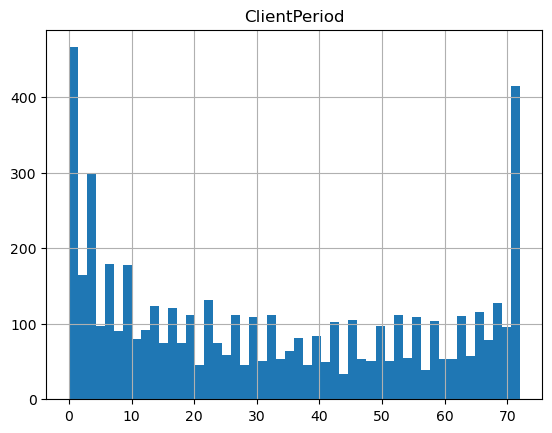

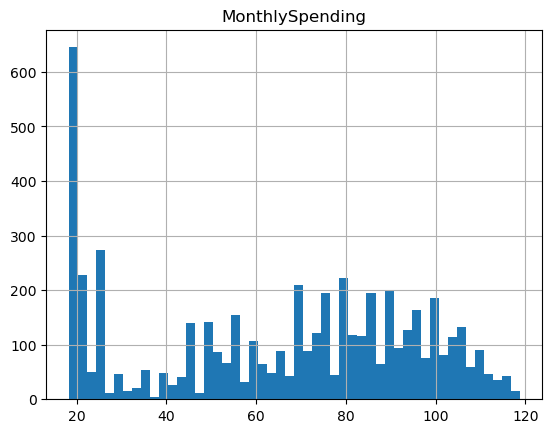

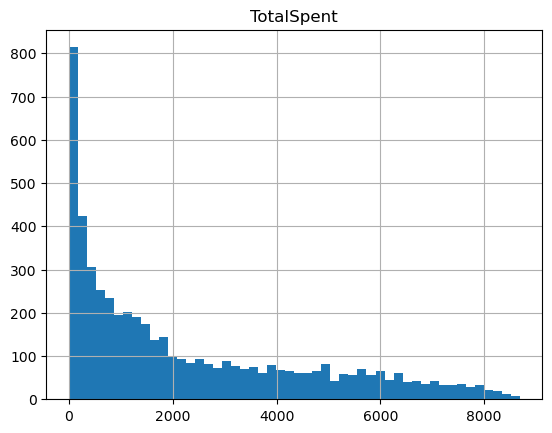

In [14]:
for col in num_cols:
    data[col].hist(bins=50)
    plt.title(col)
    plt.show()

Значения с максимумами распределения не будем считать экстремальными. Большое количество значений ClientPeriod в районе 0 можно объяснить недавно проведенной маркетинговой акцией, в районе 70 - началом деятельности.
MonthlySpending - величины в границах (0-25) - клиенты с минимальным набором услуг.
TotalSpent определяется как длительностью обслуживания, так и набором услуг.  
Введем новые признаки. Нулевое значение 'ClientPeriod' у  новых клиентов заменим на 0,5 (будем считать, что это средний период обслуживания для клиентов, кто заключил договор в пределах последнего месяца.

In [15]:
data['ClientPeriod'] = data['ClientPeriod'].replace(0,0.5)

Посмотрим, как отличается доля расторгнутых договоров для разных интервалов 'ClientPeriod':

<AxesSubplot:xlabel='test'>

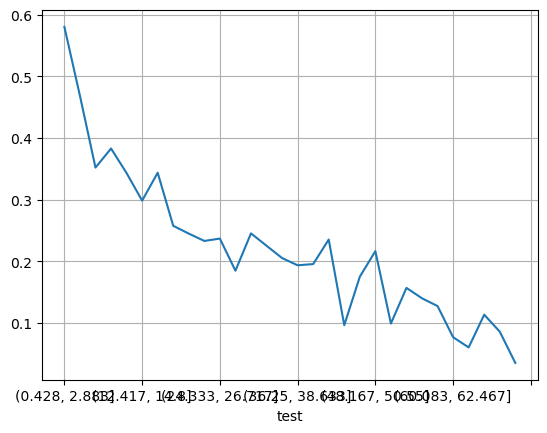

In [16]:
data['test'] = pd.cut(data ['ClientPeriod'],30)
data.groupby('test')['Churn'].mean().plot(grid=True)

Введем новый признак - логарифм от 'ClientPeriod', чтобы получить более линейную зависимость.

In [17]:
data['ClientPeriod_log'] = np.log(data['ClientPeriod'])

Аналогично построим для 'TotalSpent_next'

<AxesSubplot:xlabel='test'>

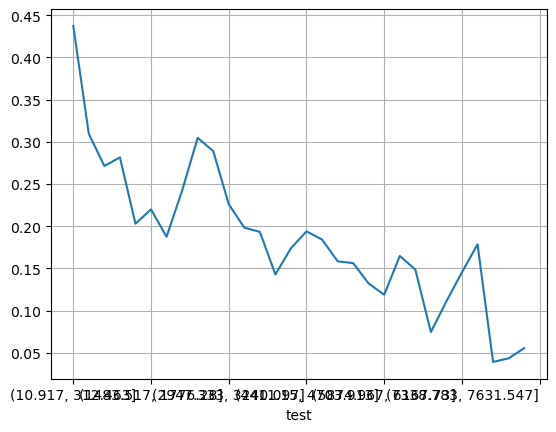

In [18]:
data['test'] = pd.cut(data ['TotalSpent_next'],30)
data.groupby('test')['Churn'].mean().plot(grid=True)

In [19]:
data['TotalSpent_log'] = np.log(data['TotalSpent_next'])

Введем ранее упомянутые отношения признаков:

In [20]:
data['charge_mean'] = data['TotalSpent_next']/data['ClientPeriod']
data['charge_months'] = np.log(data['TotalSpent_next']/data['MonthlySpending'])

Добавим признак - количество сервисов, используемых пользователем. Колонки с сервисами:

In [21]:
services_cols = [
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription'
]

Определим функцию, которая считает, что данный сервис используется, если в нем нет слова "No"

In [22]:
def num_services(x):    
    num = 0
    if x=="No":            
        return num
    else:
        num+=1
        return num

Новый признак:

In [23]:
data['serv_num']=np.zeros(len(data)).astype('int')
for _ in services_cols:     
    data['serv_num'] = data['serv_num']+(data[_].apply(lambda x: num_services(x))).astype('int')

Посмотрим, какой процент ухода у пользователей с разным количеством услуг

<AxesSubplot:xlabel='test'>

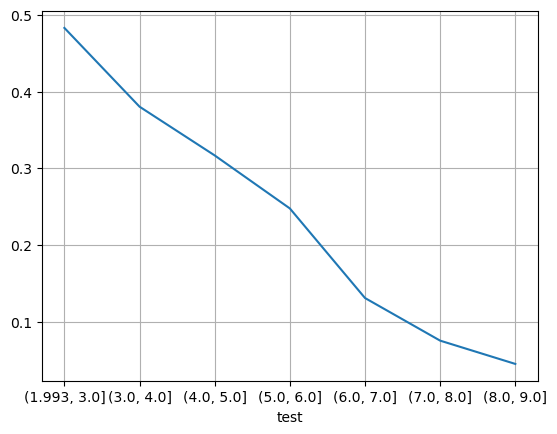

In [24]:
data['test'] = pd.cut(data ['serv_num'],7)
data.groupby('test')['Churn'].mean().plot(grid=True)

Чем больше услуг, тем меньше вероятность ухода.  
Уточним численные признаки:

In [25]:
num_cols = num_cols + [    
    'ClientPeriod_log',    
    'TotalSpent_log',
    'charge_mean',
    'charge_months',
    'serv_num'
]
feature_cols = num_cols + cat_cols

Теперь построим диаграммы для категориальных признаков.

Sex


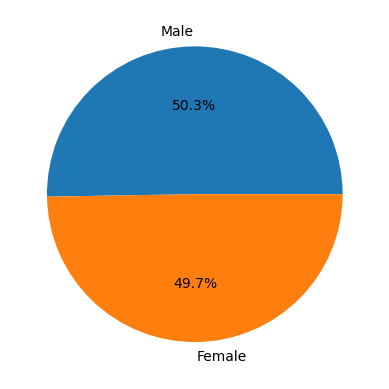

IsSeniorCitizen


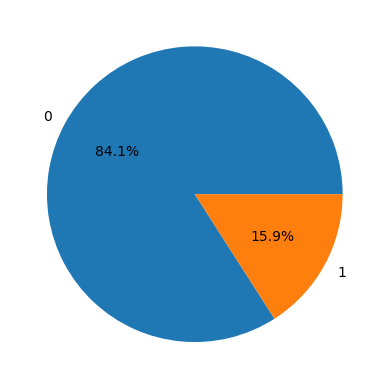

HasPartner


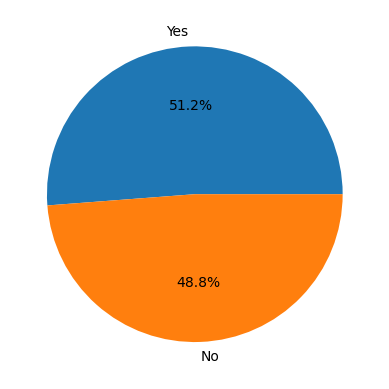

HasChild


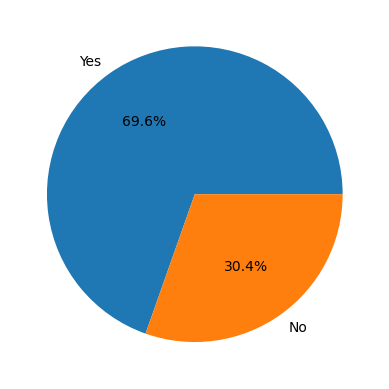

HasPhoneService


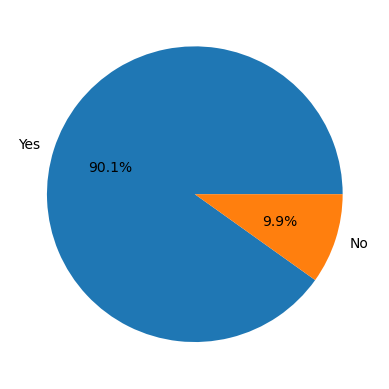

HasMultiplePhoneNumbers


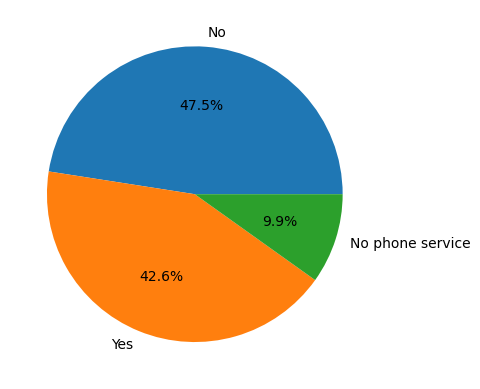

HasInternetService


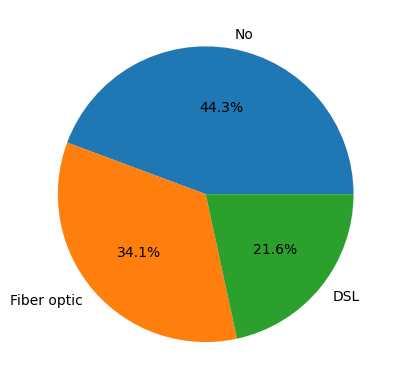

HasOnlineSecurityService


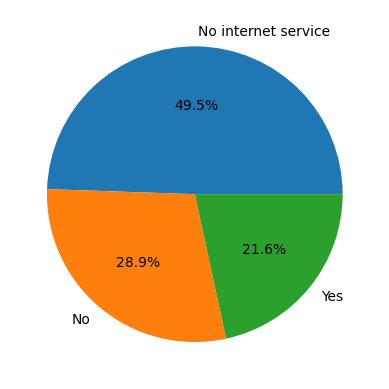

HasOnlineBackup


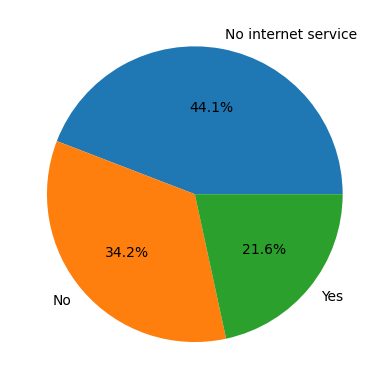

HasDeviceProtection


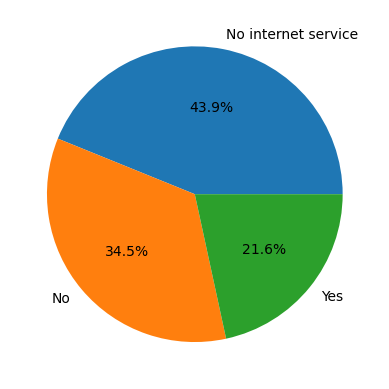

HasTechSupportAccess


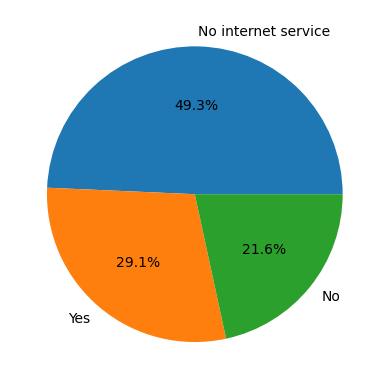

HasOnlineTV


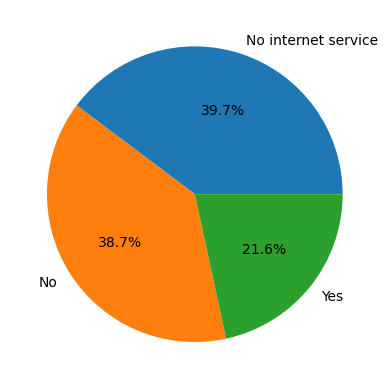

HasMovieSubscription


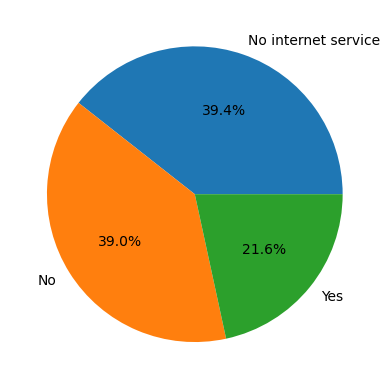

HasContractPhone


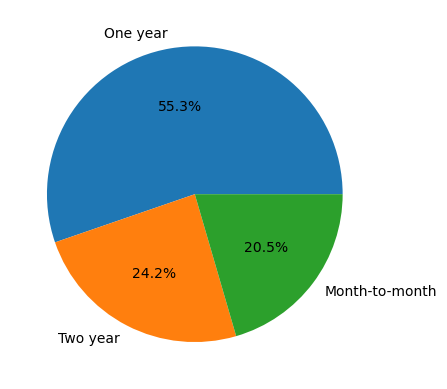

IsBillingPaperless


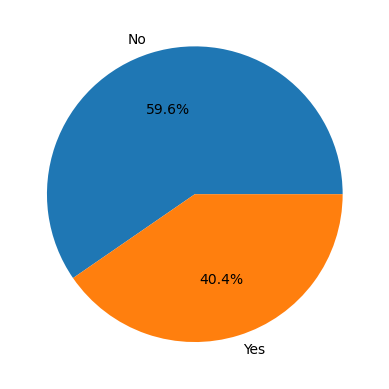

PaymentMethod


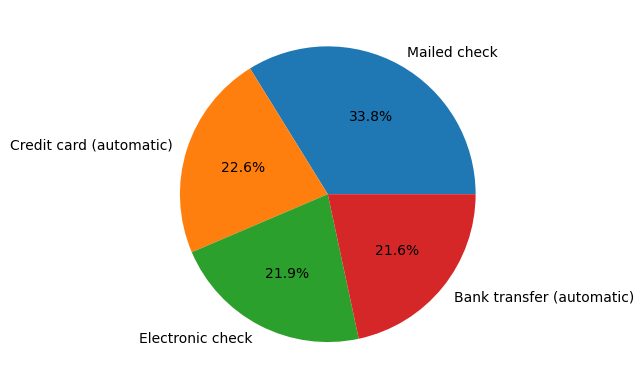

In [26]:
for col in cat_cols:
    print (col)
    plt.pie(data[col].value_counts(), labels = data[col].unique(), autopct='%.1f%%')
    plt.show()

Определим баланс данных

In [27]:
data[target_col].mean()

0.26202196137826583

Дисбаланс не очень большой. 

## Применение линейных моделей 

С помощью кроссвалидации подберем гиперпараметры линейной модели по метрике ROC-AUC. 

Для численных данных будем использовать StandardScaler(), для категориальных - OneHotEncoder.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer

In [29]:
X_train = data[feature_cols]
y_train = data[target_col]

Определим функцию для кросс-валидации GridSearch.

In [30]:
best_models=[] #массив обученных моделей
model_params=[] #массив параметров лучших моделей
def grid_search (model_pipeline, model_parameters, X, y):
    cv_grid = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)    
    grid = GridSearchCV(model_pipeline, model_parameters, cv = cv_grid, scoring = 'roc_auc')
    grid.fit(X, y)
        
    #запишем обученные модели в массив
    grid.best_estimator_.fit(X, y)
    best_models.append(grid.best_estimator_)
    
    #находим предсказания лучшей модели и значения метрики    
    prediction = grid.best_estimator_.predict(X)    
    return print ("auc_roc = {:.3f}, best_params: {}".format(grid.best_score_, grid.best_params_))   

In [31]:
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='error',drop='first')

Используем pipeline+GridSearch для LR.

In [32]:
%%time

preprocessor = make_column_transformer((scaler, num_cols),(encoder, cat_cols))
        
pipe = Pipeline([('pr',preprocessor),('model', LogisticRegression())])
params = {'model__C': [0.1,1,10,100],'model__max_iter':[500], 'model__class_weight':['balanced',None]}
grid_search (pipe, params, X_train, y_train) 

auc_roc = 0.849, best_params: {'model__C': 1, 'model__class_weight': 'balanced', 'model__max_iter': 500}
CPU times: user 9.75 s, sys: 14.1 s, total: 23.9 s
Wall time: 6.05 s


При C=1 достигатся auc_roc = 0.849.

## Применение градиентного бустинга

Попробуем градиентный бустинг. Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. Catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

Будем использовать CatBoostClassifier вместе с GridSearchCV.

In [33]:
import catboost

Зададим список номеров категориальных колонок:

In [34]:
a = []
for _ in cat_cols:
    list_cat = list(X_train.columns.values)
    a.append (list_cat.index(_))

Найдем оптимальные гиперпараметры для Catboost

In [35]:
cat_model = catboost.CatBoostClassifier(cat_features=a, verbose=False)
params = {'iterations': range(50,51,1),'depth': [4, 5, 6],'learning_rate': np.arange(0.05, 0.2, 0.05)}
grid_search (cat_model, {}, X_train, y_train)

auc_roc = 0.843, best_params: {}


auc_roc = 0.843, оптимальные значения - используемые по умолчанию.  
Посмотрим, какие результаты будут у простейшей нейронной сети.

In [36]:
from sklearn.neural_network import MLPClassifier

In [37]:
model = MLPClassifier(random_state=42)

preprocessor = make_column_transformer((scaler, num_cols),(encoder, cat_cols))
        
pipe = Pipeline([('pr',preprocessor),('model', model)])
params = {'model__max_iter':[2000], 'model__hidden_layer_sizes':[[5,5],[5]], 'model__activation': ['tanh', 'relu']} 
grid_search (pipe, params, X_train, y_train)

auc_roc = 0.845, best_params: {'model__activation': 'relu', 'model__hidden_layer_sizes': [5, 5], 'model__max_iter': 2000}


auc_roc = 0.845,как у LR.   
Последней посмотрим на модель LGBM.

In [38]:
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [39]:
model = LGBMClassifier(random_state=42)
preprocessor = make_column_transformer((scaler, num_cols),(encoder, cat_cols))
pipe = Pipeline([('pr',preprocessor), ('model', model)])
params = {'model__max_depth':[2,3,4], 'model__n_estimators':[60,70,80], 'model__learning_rate': [0.05,0.1,0.2]} #, 'model__class_weight':['balaced', None]}
grid_search (pipe, params, X_train, y_train)

auc_roc = 0.847, best_params: {'model__learning_rate': 0.1, 'model__max_depth': 2, 'model__n_estimators': 70}


У нее значение auc_roc = 0.847.  Максимальное значение - у модели LR.
Построим для всех моделей кривые auc_roc.

In [40]:
def curve(y_real, y_pred):
    fpr, tpr, threshold = roc_curve(y_real, y_pred)   
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

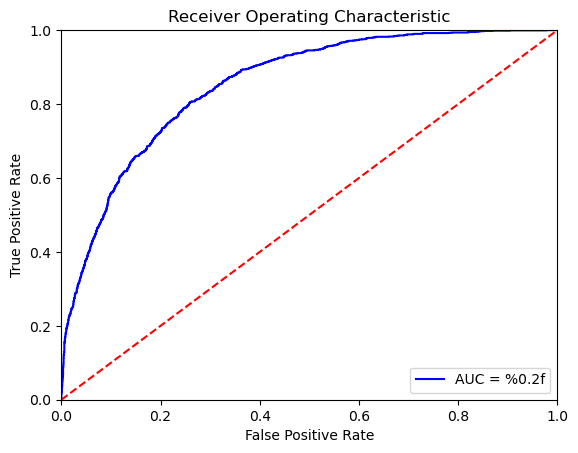

LR 0.8529113603537609


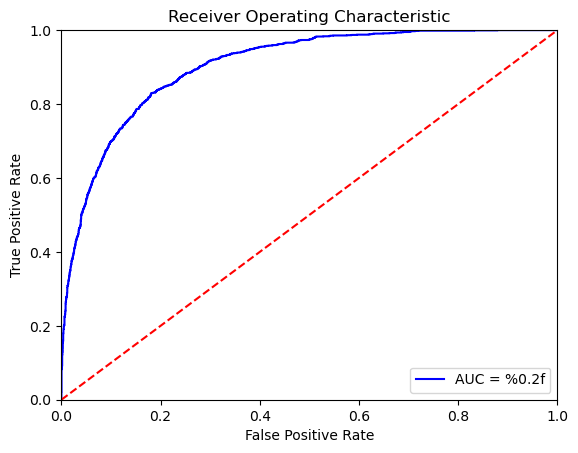

Catboost 0.9030628757299578


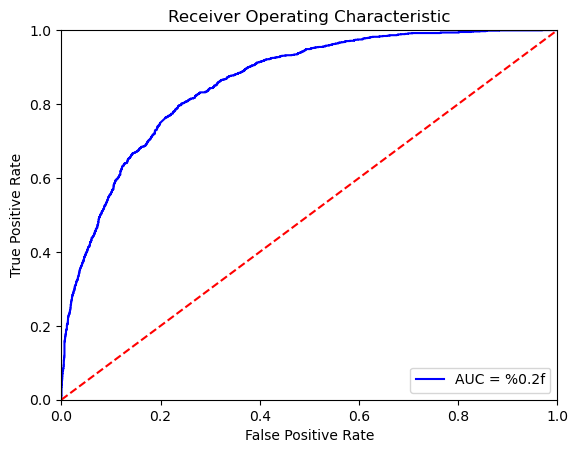

MLP 0.8587098727078062


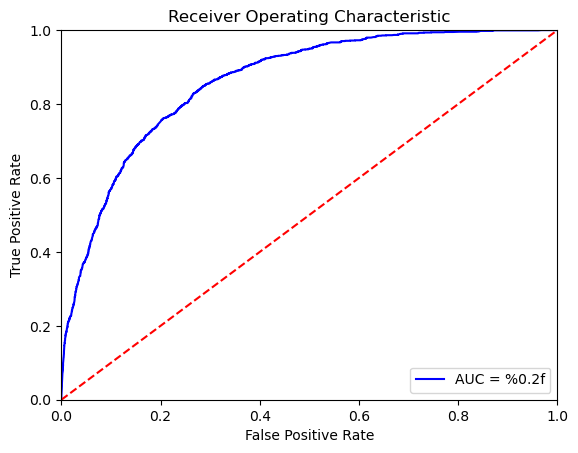

LGBM 0.8611688927477259


In [41]:
model_names = ['LR', 'Catboost','MLP', 'LGBM']
for i, model in enumerate(best_models):
    prediction = model.predict_proba(X_train)[:,1]
    curve(y_train, prediction)
    print (model_names[i],roc_auc_score(y_train, prediction))

# Предсказания

На кросс-валидации лучшие результаты получены у LR. Используем ее на тестовой выборке.

In [42]:
best_model = best_models[0]

In [43]:
X_test = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/test.csv')
submission = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/submission.csv')

Преобразуем тестовые данные точно так, как делали с обучающей выборкой:

In [44]:
df = X_test
df[cat_cols] = df[cat_cols].astype('category')
df['TotalSpent'] = df['TotalSpent'].replace(' ', 0).astype('float64')
df['TotalSpent_next'] = df['TotalSpent'] + df['MonthlySpending']
df['ClientPeriod'] = df['ClientPeriod'].replace(0,0.5)
df['ClientPeriod_log'] = np.log(df['ClientPeriod'])
df['TotalSpent_log'] = np.log(df['TotalSpent_next'])
df['charge_mean'] = df['TotalSpent_next']/df['ClientPeriod']
df['charge_months'] = np.log(df['TotalSpent_next']/df['MonthlySpending'])
df['serv_num']=np.zeros(len(df)).astype('int')

for _ in services_cols:     
    df['serv_num'] = df['serv_num']+(df[_].apply(lambda x: num_services(x))).astype('int')

Делаем предсказания.

In [45]:
submission['Churn'] = best_model.predict_proba (df[feature_cols])[:,1]
submission.to_csv('lr\my_submission.csv',index=False)

На https://www.kaggle.com/competitions/advanced-dls-spring-2021/ получен результат метрики auc_roc = 0.853. Модель показала хороший результат.